In [21]:
# Numpy imports:
import numpy as np

# for extracting filenames 
import glob

#Matplotlib imports
import matplotlib.pyplot as plt

# skimage submodules we need
import skimage.io

#Scipy imports
import scipy
from scipy import optimize
from scipy.optimize import curve_fit

In [22]:
import atp_hydro
atp_hydro.pboc_style_mpl()
# show images in viridis by default (pboc is fire?)
plt.rcParams['image.cmap'] = 'viridis'

In [23]:
#Data Params:
#Nikon_10X_bin1_20sFrameInterval_100ms480_150ms405_1uMmicro_1400nM_A81D_2
frame_int = 20 #s
ATPconc = 470 #uM
Motconc = 1 #uM
skip_int = 10 #data frames to skip 

In [78]:
#This should not change between experiments:
datapath = '../../data/atp_hydro'
#This varies between experiments.  
datafolder = '2023-11-24_Hydrolysis_QueenA81D/470uMATP_1'

#--------- Read in Files -----------#
# bound Images
included_bound = '*405*.tif'
bound_files = np.sort(glob.glob(datapath+'/'+datafolder+'/'+included_bound))[::skip_int]

# unbound Images
included_unbound = '*480*.tif'
unbound_files = np.sort(glob.glob(datapath+'/'+datafolder+'/'+included_unbound))[::skip_int]
#--------------

# Convert files to images and save as array:
bound_array = atp_hydro.file_to_image(bound_files)
unbound_array = atp_hydro.file_to_image(unbound_files)

# ------------------------------------------------------------------------------ #
#Background 
bound_bg = 1914
unbound_bg = 1914

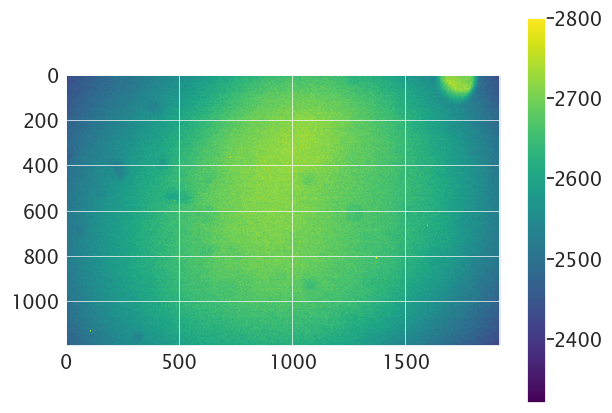

In [79]:
samp_im = bound_array[10]
plt.imshow(samp_im, vmin=np.percentile(samp_im, 0), vmax=np.percentile(samp_im,99.99))
plt.colorbar()

In [80]:
#Subtract im_dark from all calibration images
bound_bs = bound_array - bound_bg
unbound_bs = unbound_array - unbound_bg

#set negative values to zero
unbound_bs[unbound_bs<0] = 0
bound_bs[bound_bs<0] = 0

In [81]:
atp_hydro.norm_mat_fn_iATP?

Signature: atp_hydro.norm_mat_fn_iATP(im_ref, im_dark, r_blur=3)
Docstring:
Generate a normalization matrix from a reference image.

This function corrects for uneven illumination. It takes in a reference image which should be the zero 
ATP control. It then finds the brightest point of the image and for each pixel replaces the pixel value 
with (brightest pixel value)/(initial pixel value). This creates a matrix that when multiplied by the 
original image with flatten the illumination and raise every pixel to the brightest value. You can then 
multiply this normalization matrix by all other images in the dataset to flatten the illumination in each image.

It is assumed that the reference image is taken for a sample with a spatially uniform protein concentration. The 
normalization value is everywhere greater than 1, except at the position of the highest illumination.

Parameters
----------
im_ref : numpy array
    Reference image (e.g., the first frame in the MT channel).

offset_camer

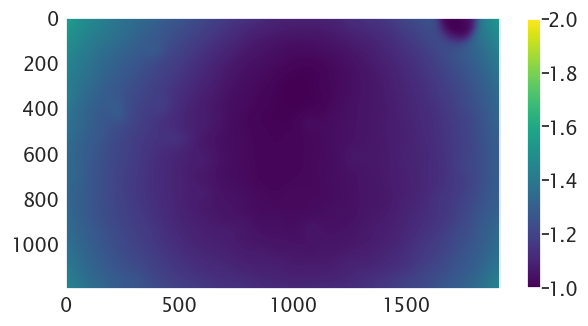

In [82]:
#Find the normilization matrix
bound_norm_mat = atp_hydro.norm_mat_fn_iATP(bound_array[-1], bound_bg)
unbound_norm_mat = atp_hydro.norm_mat_fn_iATP(unbound_array[-1], unbound_bg)

#plot the normalizaiton matrix
plt.imshow(bound_norm_mat, vmin = 1, vmax = 2)
plt.colorbar(shrink = 0.7)
plt.grid(False)

In [83]:
#Normalize all the claibration images by multiplying by the normalization matrix
bound_norm = bound_bs*bound_norm_mat
unbound_norm = unbound_bs*unbound_norm_mat

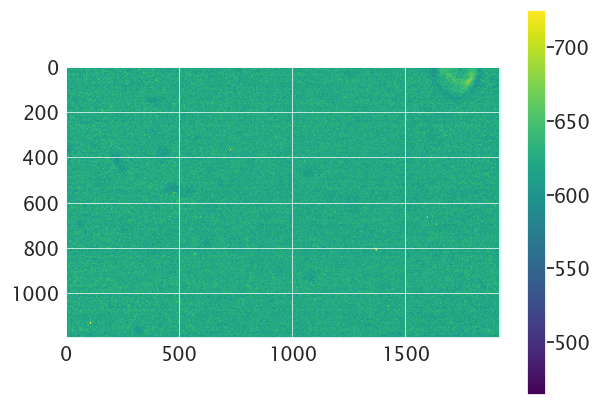

In [84]:
samp_im = bound_norm[200]
plt.imshow(samp_im, vmin=np.percentile(samp_im, 0), vmax = np.percentile(samp_im, 99.99))
plt.colorbar()

In [85]:
#Average intensities
bound_hydro = np.average(bound_norm, axis=(1,2))
unbound_hydro = np.average(unbound_norm, axis=(1,2))
ratio_hydro = bound_hydro/unbound_hydro

In [86]:
time = np.arange(0, len(ratio_hydro), 1)*frame_int*skip_int #s

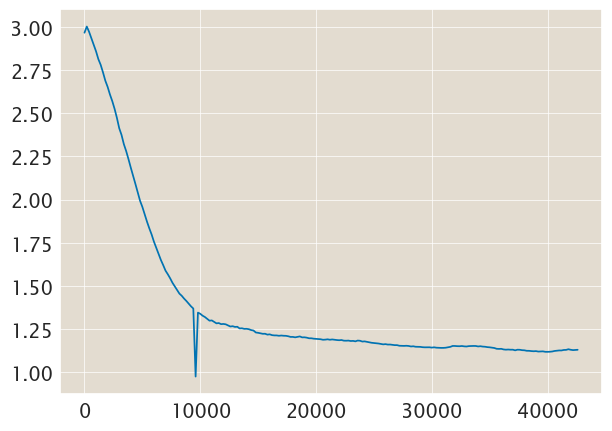

In [87]:
plt.plot(time, ratio_hydro)

In [88]:
def ATP_inten_to_conc(array, a, b, c, d):
    return a * ((c - array) / (array - b)) ** (1/d)

/var/folders/8p/dg75nl0d7ml8f_vqy6lvm3740000gn/T/ipykernel_22418/1203200823.py:2: RuntimeWarning: invalid value encountered in power
  return a * ((c - array) / (array - b)) ** (1/d)


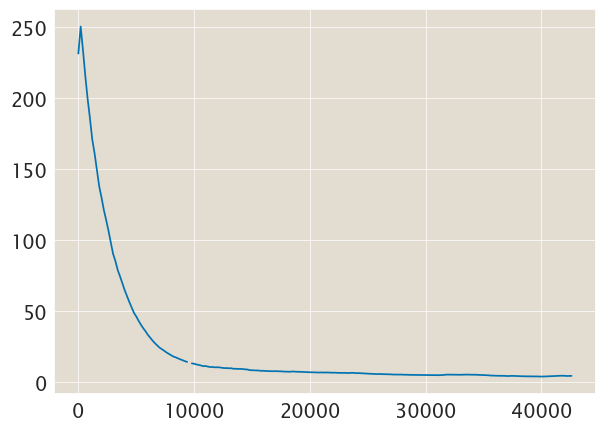

In [89]:
ratio_concavg = ATP_inten_to_conc(ratio_hydro, 72.10715431,  3.48382794,  1.0316845,   1.12716404)
plt.plot(time, ratio_concavg)

In [90]:
#Remove any nans

#find nans
nans = np.where(np.isnan(ratio_concavg)==True)

#remove
ratio_hydro_uM = np.delete(ratio_concavg, nans)
times = np.delete(time, nans)

In [91]:
def expfunc(time, tau, Ao, Ainf):
    return (Ao-Ainf)*np.exp(-time/tau) + Ainf
def expfit(time, norm_conc, p0):
    #Curve fits and returns parameter values as well as the covarience
    param, param_cov = curve_fit(expfunc, 
                                 time, 
                                 norm_conc, 
                                 p0, 
                                 bounds = (np.zeros(3), np.ones([3])*np.inf))

    #stores the new function information according to the coefficients given by curve-fit() function 
    curve = expfunc(time, param[0], param[1], param[2])
    
    return param, curve

In [92]:
params, curve = expfit(times, ratio_hydro_uM, [2000, 500, 50])

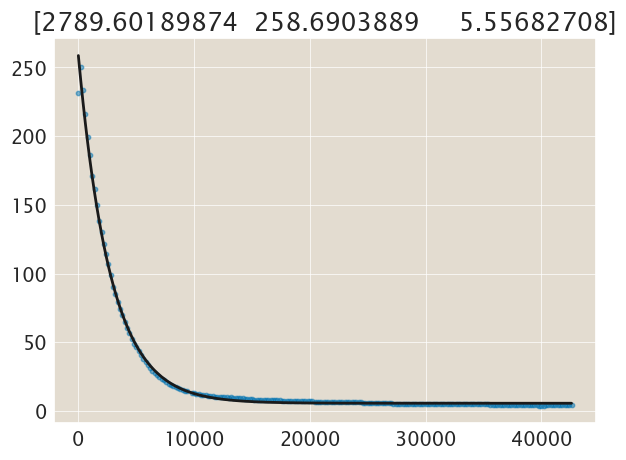

In [93]:
plt.scatter(times, ratio_hydro_uM, alpha=0.5, s=10)
plt.plot(times, curve, color='k', linewidth=2)
plt.title(str(params));

In [94]:
ATPsat = np.max(ratio_hydro_uM) #uM
Decay=params[0] #s
slope = ATPsat/Decay #uM/s
rate = ATPsat/Decay/Motconc
print("ATP/mot*s Hydrolysis rate: " +str(rate))

ATP/mot*s Hydrolysis rate: 0.08983963430259441
